<h1 align="center">Language Models</h1>

Before we can do things with words, we need some words. Here we'll use the NLTK library to fetch a commonly used list of text files.

In [1]:
import nltk
nltk.download('gutenberg')

from nltk.corpus import gutenberg
gutenberg.fileids()

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [2]:
import re
words = gutenberg.words('austen-emma.txt')

# filter out numbers, etc.
words = [w.lower() for w in words if re.match('^[a-zA-Z]+$', w)]
words[:10]

['emma',
 'by',
 'jane',
 'austen',
 'volume',
 'i',
 'chapter',
 'i',
 'emma',
 'woodhouse']

words can also serve as a generative model of text. We know that language is very complicated, but we can create a simplified model of language that captures part of the complexity. In the bag of words model, we ignore the order of words, but maintain their frequency. Think of it this way: take all the words from the text, and throw them into a bag. Shake the bag, and then generating a sentence consists of pulling words out of the bag one at a time. Chances are it won't be grammatical or sensible, but it will have words in roughly the right proportions. 

Here's a function to sample an n word sentence from a bag of words:

In [3]:
import random

def sample(w, n=10):
    """Sample n words from a list of words, w."""
    return [random.choice(w) for _ in range(n)]

sample(words)

['voice',
 'interest',
 'all',
 'goddard',
 'so',
 'be',
 'vain',
 'fairfax',
 'it',
 'plaister']

## From Bag of Words to Probabilities

From the bag of words, we can construct a frequency table:

In [4]:
from collections import Counter

word_counts = Counter(words)
word_counts.most_common(10)

[('to', 5239),
 ('the', 5201),
 ('and', 4896),
 ('of', 4291),
 ('i', 3178),
 ('a', 3129),
 ('it', 2528),
 ('her', 2469),
 ('was', 2398),
 ('she', 2340)]

In [5]:
len(word_counts)

7079

And from the frequency table, a probability distribution:

In [6]:
import pandas as pd

def pdist(counter):
    """Make a probability distribution from a Counter."""
    n_words = sum(counter.values())
    dist = [(word, count/n_words) for word, count in counter.items()]
    return pd.DataFrame(data=dist, columns=['words', 'probs'])

word_probs = pdist(word_counts)
word_probs.sort_values('probs', ascending=False).head(5)

,words,probs
858,to,0.032420
2460,the,0.032184
4906,and,0.030297
6104,of,0.026553
1481,i,0.019666


In [26]:
word_probs['probs'].sum()

1.0000000000000027

Let's consolidate what we've learned so far into a function.

In [8]:
def words_to_pdist(words):
    """Make a probability distribution from a list of words."""
    
    wc = Counter(words)
    n_words = sum(wc.values())
    dist = [(word, count, count/n_words) for word, count in wc.items()]
    
    return pd.DataFrame(data=dist, columns=['words', 'counts', 'probs'])

unigram_probs = words_to_pdist(words)
unigram_probs.sort_values('probs', ascending=False).head(5)

,words,counts,probs
858,to,5239,0.032420
2460,the,5201,0.032184
4906,and,4896,0.030297
6104,of,4291,0.026553
1481,i,3178,0.019666


Using the probability / frequency table above, can we assign a probability to a sentence?

## The Bag of Words Model

The bag of words model assumes all the words are independent. The the joint probability of a sentence is just the product of the individual probabilities.

$P(w_1 \ldots w_n) = P(w_1) \times P(w_2) \times P(w_3) \ldots  \times \ldots P(w_n)$

In [9]:
def unigram_model(unigram_probs, sent):
    """Calculate unigram probability of a string of words, sent."""    
    idx_uni = unigram_probs.set_index('words')
    return idx_uni.loc[sent, 'probs'].prod()

sent = ['to', 'the', 'end']
p_sent = unigram_model(unigram_probs, sent)

print('Probability of %s is [%.8f]' % (sent, p_sent))

Probability of ['to', 'the', 'end'] is [0.00000031]


## The Bigram Model

Use the Chain Rule of Probability to break down the full joint distribution

$P(w_1 \ldots w_n) = P(w_1) \times P(w_2 \mid w_1) \times P(w_3 \mid w_1 w_2) \ldots  \times \ldots P(w_n \mid w_1 \ldots w_{n-1})$

To make this more useful, we make the Markov assumption that only successive words depend on each other.

$P(w_1 \ldots w_n) = P(w_1) \times P(w_2 \mid w_1) \times P(w_3 \mid w_2) \ldots  \times \ldots P(w_n \mid w_{n-1})$

In [10]:
def bigram_gen(words):
    """Given a word list, generate successive pairs of words."""
    for i in range(len(words)-1):
        yield tuple(words[i:i+2])

bigram_probs = words_to_pdist(bigram_gen(words))
bigram_probs.sort_values('probs', ascending=False).head(5)

,words,counts,probs
10918,"(to, be)",607,0.003756
24842,"(of, the)",566,0.003502
14958,"(it, was)",448,0.002772
19146,"(in, the)",446,0.002760
8780,"(i, am)",395,0.002444


How to calculate $P(w_i \mid P(w_{i-1})$? This is simply count of the bigram $(w_i-1, w_{i-1})$ divided by the number of bigrams starts with $w_i$, which equals the unigram count of $w_i$.

In [11]:
def bigram_model(unigram_probs, bigram_probs, sent):
    """Calcuate bigram probability of a list of words, sent."""
    idx_uni = unigram_probs.set_index('words')
    idx_bi = bigram_probs.set_index('words')
    
    p_sent = idx_uni.loc[sent[0], 'probs'] #P(sent[0])
    
    for w1, w2 in bigram_gen(sent):
        p_w1_w2 = idx_bi.loc[[(w1, w2),], 'probs'].values[0]
        print('P(%s | %s) is [%.8f]' % (w2, w1, p_w1_w2))
        p_sent*= p_w1_w2
                         
    return p_sent

bigram_model(unigram_probs, bigram_probs, ['to', 'be', 'or', 'not', 'to', 'be'])

P(be | to) is [0.00375621]
P(or | be) is [0.00000619]
P(not | or) is [0.00006807]
P(to | not) is [0.00045792]
P(be | to) is [0.00375621]


8.8229838490342123e-20

## Missing Words and Smoothing

What if our test sentence contains words that we haven't encountered yet? In this case, our model will fail. 

No matter how big the size of our word database, we can't reliably expect to see all known words beforehand. Our language model needs to able to handle open classes of words: nouns, verbs and adjectives. 

## Add-one (or Laplace) Smoothing

In Add-one smoothing, we assign a small, fixed probability to each unknown word. 

In [12]:
import numpy as np

def unigram_model_with_laplace_smoothing(unigram_probs, sent, k=1):
    """Calculate unigram probability of a string of words, using Laplace Smoothing for unknown words. 
    Returns log probability."""    
    idx_uni = unigram_probs.set_index('words')
    V = idx_uni.shape[0]
    
    N = idx_uni.loc[:, 'counts'].sum()
        
    p_sent = 0.0
    
    for word in sent:
        c_word = idx_uni.loc[word, 'counts'] if word in idx_uni.index else 0                       
        p_word = (c_word + k) / (N + k*V)        
        print('Word [%s], prob [%.8f]' % (word, p_word))
        p_sent += np.log(p_word)
            
    return p_sent

In [13]:
sent = ['dipanjan', 'is', 'boring', 'us', 'to', 'death']
p_sent = unigram_model_with_laplace_smoothing(unigram_probs, sent)
print('Log probability of %s is [%.3f]' % (sent, p_sent))ff

Word [dipanjan], prob [0.00000593]
Word [is], prob [0.00735717]
Word [boring], prob [0.00000593]
Word [us], prob [0.00086555]
Word [to], prob [0.03106492]
Word [death], prob [0.00006521]
Log probability of ['dipanjan', 'is', 'boring', 'us', 'to', 'death'] is [-49.145]


## Good-Turing Smoothing

<table>
    <tr>
        <td><img src="http://history.computer.org/pioneers/images/good.jpg" /></td>
        <td><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSTeWjVHv453Q-mZEQfOX9D-cOuVL-3M06AZajrM_OSamXvD85W" /></td>
    </tr>
</table>
      
The main drawback of add-one smoothing is that all unknown words are treated equally. Good-Turing smoothing is a way of differentiating between unknowns.

To calculate the Good-Turing probability of an n-gram $P(w_i)$, we use the notion of frequency of frequencies ${N_c}$ i.e. ${N_c}$ is the number of n-grams appearing c times in our vocabulary. For example:

In [14]:
counts = Counter('Sam I am I am Sam Sam dont eat fish'.split(' '))
for w, c in counts.items():
    print(w, c)

Sam 3
eat 1
dont 1
am 2
I 2
fish 1


Based on that vocabulary, $N_1$ = 3, $N_2$ = 2, $N_3$ = 1.

The MLE of $P(w_i)$ was $N_{w_i}/N$. To calculate the GT smoothed probability $P(w_i)_{GT}$ of an n-gram:

* First calculate $c* = (c+1)\frac {N_{c+1}} {N_c}$.
* Then, $P(w_i)_{GT} = \frac {c*} {N}$.

As an example, let's calculate $P(elephant)_{GT}$. elephant isn't in the vocabulary, so 

$c*_{elephant} = (0+1) \frac {N_1} {N_0} = (1*3)/1 = 3$. Thus, $P(elephant)_{GT} = 3/10$.

What about $P(am)_{GT}$? 

$c*_{am} = (2+1) \frac {N_3} {N_2} = (3*1)/2 = 3/2$. Thus, $P(am)_{GT} = 3/20$. Note that $P(am)_{MLE} = 2/10$ > $P(am)_{GT}$.

In [15]:
def unigram_model_with_good_turing_smoothing(unigram_probs, sent, k=1):
    """Calculate unigram probability of a string of words, using Laplace Smoothing for unknown words. 
    Returns log probability.""" 
    
    Ncs = unigram_probs['counts'].value_counts() # frequency of frequencies    
    idx_uni = unigram_probs.set_index('words')    
     
    N = idx_uni.loc[:, 'counts'].sum()
        
    p_sent = 0.0
    
    for word in sent:
        if word in idx_uni.index:
            # c* = (c+1) N_{c+1}/N_c, P(w) = c*/N
            c = idx_uni.loc[word, 'counts']
            c_star = (c+1) * Ncs[c+1] / Ncs[c]
            p_word = c_star / N
        else: 
            # P(w) = N_1/N
            p_word = Ncs[1] / N
        print('Word [%s], prob [%.8f]' % (word, p_word))
        p_sent += np.log(p_word)
            
    return p_sent

In [16]:
sent = ['probably', 'coming', 'home']
p_sent_gt = unigram_model_with_good_turing_smoothing(unigram_probs, sent)
print('\nLog probability of %s using GT [%.3f]\n' % (sent, p_sent_gt))

p_sent_laplace = unigram_model_with_laplace_smoothing(unigram_probs, sent)
print('\nLog probability of %s using Laplace(1) smoothing [%.3f]\n' % (sent, p_sent_laplace))

Word [probably], prob [0.00011448]
Word [coming], prob [0.00074257]
Word [home], prob [0.00081064]

Log probability of ['probably', 'coming', 'home'] using GT [-23.398]

Word [probably], prob [0.00021935]
Word [coming], prob [0.00053356]
Word [home], prob [0.00077662]

Log probability of ['probably', 'coming', 'home'] using Laplace(1) smoothing [-23.121]



## Limitations of Good-Turing Smoothing

1. Lower frequencies are noisy.

Populating the interactive namespace from numpy and matplotlib


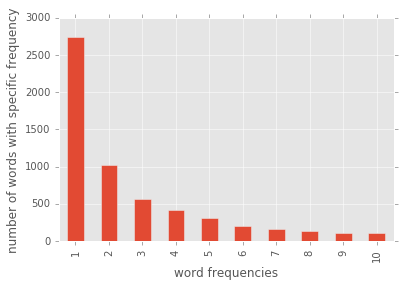

In [24]:
%pylab inline
pylab.style.use('ggplot')

unigram_counts = unigram_probs['counts'].value_counts().sort_index()
ax = unigram_counts.head(10).plot(kind='bar')
ax.set(xlabel='word frequencies', ylabel='number of words with specific frequency')

2. Upper frequencies are sparse (i.e.have gaps in them).

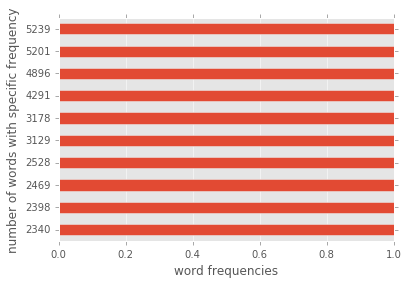

In [28]:
ax = unigram_counts.sort_index().tail(10).plot(kind='barh')
ax.set(xlabel='word frequencies', ylabel='number of words with specific frequency')

## Further Reading

1. Much of this work is based on Peter Norvig's notebook <a href="http://nbviewer.ipython.org/url/norvig.com/ipython/How%20to%20Do%20Things%20with%20Words.ipynb">How to Do Things with Words, or Statistical Natural Language Processing in Python.</a>
2. <a href="http://www.grsampson.net/AGtf1.html">Good-Turing frequency estimation without tears by: W. Gale, G. Sampson, Journal of Quantitative Linguistics, Vol. 2 (1995), pp. 217-237</a>

In [ ]:
gg